In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# BUILDING MACHINE LEARNING MODEL 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras import callbacks
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [3]:
"""MIN-MAX SCALER"""
def MMS(input_spectra):
    return MinMaxScaler().fit_transform(input_spectra)

"""STANDARD SCALER"""
def SS(input_spectra):
    return StandardScaler().fit_transform(input_spectra)

"""SIMPLE MOVING AVERAGE"""
def sma(input_spectra, window_size):
    df = pd.DataFrame(input_spectra)
    moving_averages = df.rolling(window_size, min_periods=1).mean()#.iloc[window_size-1:].values
    return moving_averages

"""MULTIPLICATIVE SCATTER CORRECTION"""
def msc(input_spectra, reference=None):
    # --- Mean center correction
    for i in range(input_spectra.shape[0]):
        input_spectra[i,:] -= input_spectra[i,:].mean()
    # --- Get the reference spektrum. If no given, estimate it from the mean
    if reference is None:
        # --- Calculate mean
        ref = np.mean(input_spectra, axis=0)
    else:
        ref = reference
    # --- Define a new array and populate it with the corrected data
    data_msc = np.zeros_like(input_spectra)
    for i in range(input_spectra.shape[0]):
        # --- Run regression
        fit = np.polyfit(ref, input_spectra[i,:], 1, full=True)
        # --- Apply correction
        data_msc[i,:] = (input_spectra[i,:] - fit[0][1]) / fit[0][0]
    return data_msc, ref

"""STANDARD NORMAL VARIATE"""
def snv(input_spectra):
    # --- Define a new array and populate it with the corrected data
    output_data = np.zeros_like(input_spectra)
    for i in range(input_spectra.shape[0]):
        # --- Apply correction
        output_data[i,:] = (input_spectra[i,:] - np.mean(input_spectra[i,:])) / np.std(input_spectra[i,:])
    return output_data

"""SAVITZKY-GOLAY SMOOTHING"""
def SG_smoothing(input_data, window_size, polyorder):
    SG_smoothing =savgol_filter(input_data,
                                window_length=window_size,
                                polyorder=polyorder,
                                mode="nearest")
    return SG_smoothing

"""SAVITZKY-GOLAY DERIVATIVE"""
def SG_derivative(input_data, window_size, polyorder, derivative):
    SG_filter = savgol_filter(input_data,
                              window_length=window_size,
                              polyorder=polyorder,
                              deriv=derivative,
                              delta=1.0,
                              axis=-1,
                              mode='interp', #'nearest'
                              cval=0.0)
    return SG_filter

#https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/
#https://pypi.org/project/pyspectra/

"""PLOT SPECTRA"""
def plot_spectra(x, y):
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot()
    ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue
    ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black
    ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    plt.plot(x, y.T)
    plt.xticks(fontsize=12, fontname="Segoe UI")    # np.arange(400, 1000, step=50),
    #plt.yticks(np.arange(ymin, ymax, step=interval), fontsize=12, fontname="Segoe UI")
    plt.title('PLOT SPECTRA', fontweight='bold', fontsize=12, fontname="Segoe UI")
    plt.ylabel('Reflectance (%)', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.grid(False) # visible=None, which='major', axis='both', **kwargs
    plt.show()

"""DATA VARIABLES"""
def variable_data(data):
    # --- Label
    label_species = data.values[:,1].astype('uint8')
    label_origins = data.values[:,2].astype('uint8')
    # --- Spectra data
    spectra = data.values[:,3:].astype('float')
    # --- Wavelengths
    cols = list(data.columns.values.tolist())
    wls = [float(x) for x in cols[3:]]
    return label_species, spectra, wls

def plot_average_spectra(wls, mean1, mean2, legend):
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot()
    ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue
    ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black
    ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    plt.plot(wls, mean1.T)
    plt.plot(wls, mean2.T)
    plt.xticks(fontsize=12, fontname="Segoe UI")    # np.arange(400, 1000, step=50),
    plt.yticks(np.arange(0, 0.5, step=0.05), fontsize=12, fontname="Segoe UI")
    #plt.title('PLOT SPECTRA', fontweight='bold', fontsize=12, fontname="Segoe UI")
    plt.ylabel('Reflectance (%)', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.legend(legend, loc = 'lower right')
    plt.grid(False) # visible=None, which='major', axis='both', **kwargs
    plt.show()

"""LOAD DATASET"""
def load_data(data):
    dataset = pd.read_csv(data)
    return dataset

"""SPECTRA PREPROCEESING"""
def preprocessing(spectra, wls, windowsize, polyorder):
    # Pre-processed Spectra
    df_sma = sma(spectra, window_size=windowsize)
    df_sgs = SG_smoothing(spectra, window_size=windowsize, polyorder=polyorder)
    df_msc = msc(spectra)[0]
    df_snv = snv(spectra)
    df_sgd1 = SG_derivative(spectra, window_size=windowsize, polyorder=polyorder, derivative=1)
    df_sgd2 = SG_derivative(spectra, window_size=windowsize, polyorder=polyorder, derivative=2)
    #plot_spectra(wls, df_sma)
    #plot_spectra(wls, df_sgs)
    #plot_spectra(wls, df_msc)
    #plot_spectra(wls, df_snv)
    #plot_spectra(wls, df_sgd1)
    #plot_spectra(wls, df_sgd2)
    return df_sma, df_sgs, df_msc, df_snv, df_sgd1, df_sgd2

# https://sebastianraschka.com/Articles/2015_pca_in_3_steps.html#covariance-matrix
# https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html

"""PRINCIPAL COMPONENT ANALYSIS"""
def pca1(input_spectra, wavelengths, label, label_name, num_comps):
    pca = PCA(n_components=num_comps)
    """Fit the spectral data and extract the explained variance ratio"""
    X = pca.fit(input_spectra)
    """Explained variances equal to n_components largest eigenvalues of the covariance matrix of X."""
    var_expl = X.explained_variance_
    for a in var_expl:
        if(a>0.5):
            print('Sorted Eignevalues: {}'.format(round(a, 3)))
    """Percentage of variance explained by each of the selected components."""
    var_expl_ratio = X.explained_variance_ratio_
    for b in var_expl_ratio:
        print('Explained Variance: {}%'.format(round(b*100, 2)))
    """Scree Plot"""
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(7,4))
        fig.set_tight_layout(True)
        ax.plot(var_expl_ratio, '-o', label='Explained Variance %')
        ax.plot(np.cumsum(var_expl_ratio), '-o', label = 'Cumulative Variance %')
        ax.set_ylabel('Cumulative Explained Variance')
        ax.set_xlabel('Number of Components')
        ax.set_yticks(np.arange(0.0, 1.1, step=0.1), fontsize=12, fontname="Segoe UI")
        ax.set_xticks(np.arange(0, 10, step=1), fontsize=12, fontname="Segoe UI")
        #ax.set_title('Scree plot: Original Spectra')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.set_facecolor("white")
    plt.legend()
    plt.show()

    """Get Principle Components (PCs) or PCA scores"""
    # Transform on the scaled features
    Xcomps = pca.fit_transform(input_spectra)
    Xcomps = SS(Xcomps)

    """PCA Score Plot"""
    PCs_var = var_expl_ratio*100
    unique = list(set(label))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(8,7))
        #ax = fig.add_subplot(111, projection='3d')
        for i, u in enumerate(unique):
            col = np.expand_dims(np.array(colors[i]), axis=0)
            pc1 = [Xcomps[j,0] for j in range(len(Xcomps[:,0])) if label[j] == u]    # PC1
            pc2 = [Xcomps[j,1] for j in range(len(Xcomps[:,1])) if label[j] == u]    # PC2
            pc3 = [Xcomps[j,2] for j in range(len(Xcomps[:,2])) if label[j] == u]    # PC3
            plt.scatter(pc1, pc2, #
                        c=col, s=20, edgecolors='k', label=str(u))
        plt.xlabel('PC1 ('+str(round(PCs_var[0],2))+'%)', fontsize=12)   # ---------------------- < CHANGE INPUT
        plt.ylabel('PC2 ('+str(round(PCs_var[1],2))+'%)', fontsize=12)   # ---------------------- < CHANGE INPUT
        plt.legend(label_name, loc = 'lower left')
        #plt.title('2D PCA ' + f'(Total Explained Variance: {total_var:.2f}%)')
        ax.axhline(y=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Horizontal Line ')
        ax.axvline(x=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Vertical Line ')
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')
        yabs_max = abs(max(ax.get_ylim(), key=abs))
        ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
        xabs_max = abs(max(ax.get_xlim(), key=abs))
        ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.set_facecolor("white")
        plt.show()

    """Principal components correlation coefficients"""
    loadings = pca.components_
    num_pcs = pca.n_features_in_

    pc_list = ['PC'+ str(i) for i in list(range(1, num_pcs+1))]
    loadings_df =pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))

    plt.style.context(('ggplot'))
    plt.figure(figsize=(8, 5))
    #plt.plot(wavelengths, loadings_df['PC5'], label='PC5')
    #plt.plot(wavelengths, loadings_df['PC4'], label='PC4')
    plt.plot(wavelengths, loadings_df['PC3'], label='PC3')
    plt.plot(wavelengths, loadings_df['PC2'], label='PC2')
    plt.plot(wavelengths, loadings_df['PC1'], label='PC1')
    plt.ylabel('PCA Loadings', fontsize=12, fontname="Segoe UI")
    #plt.ylabel('PC1 ('+str(round(PCs_var[0],2))+'%)', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.axhline(y=0.0, color='black', linestyle='-')
    plt.legend(loc = 'lower left')
    plt.show()

    return Xcomps

def pca2(input_spectra, wavelength, label, label_name, n_components):
    row, col = input_spectra.shape

    """STEP 1 - STANDARDIZE DATA"""
    #data = StandardScaler().fit_transform(inputdata)

    """STEP 2 - COVARIANCE MATRIX"""
    mean_vector = np.mean(input_spectra, axis=0)
    covmat = (input_spectra - mean_vector).T.dot((input_spectra - mean_vector))/(input_spectra.shape[0]-1)
    #print('Covariance Matrix \n%s' %covmat)
    # cara lain
    covmat1 = np.cov(input_spectra.T)

    """STEP 3 - EIGEN DECOMPOSITION"""
    # Eigen from covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covmat1)
    # Eigen from correlatioin matrix
    cormat = np.corrcoef(input_spectra.T)
    eigenvalues1, eigenvectors1 = np.linalg.eig(cormat)

    """STEP 4 - SELECTING PCs"""
    # Make a list of (eigenvalue, eigenvector) tuples
    eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(len(eigenvalues))]
    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eigen_pairs.sort(key=lambda x: x[0], reverse=True)
    # Visually confirm that the list is correctly sorted by decreasing eigenvalues
    for a in eigen_pairs:
        if(a[0]>0.5):
            print('Sorted Eignevalues: {}'.format(a[0]))

    """STEP 5 EXPLAINED VARIANCE"""
    total_var = sum(eigenvalues)
    var_exp = [(i/total_var) for i in sorted(eigenvalues, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    print('Cumulative Explained Variation PC : {}%'.format(cum_var_exp[n_components]*100))
    print('EXPLAINED VARIATION')
    for b in var_exp:
        print('Explained variation PC : {}%'.format(b*100))

    """STEP 6 PROJECTION MATRIX"""
    matrix_w = np.hstack((eigen_pairs[0][1].reshape(col,1),
                          eigen_pairs[1][1].reshape(col,1),
                          eigen_pairs[2][1].reshape(col,1),
                          eigen_pairs[3][1].reshape(col,1),
                          eigen_pairs[4][1].reshape(col,1),
                          eigen_pairs[5][1].reshape(col,1),
                          eigen_pairs[6][1].reshape(col,1),
                          eigen_pairs[7][1].reshape(col,1),
                          eigen_pairs[8][1].reshape(col,1),
                          eigen_pairs[9][1].reshape(col,1)))

    """STEP 7 - TRANSFORM THE ORIGINAL MATRIX TO PCs"""
    scores = input_spectra.dot(matrix_w)
    #scores = SS(scores)
    pc_list = ['PC'+ str(i) for i in list(range(1, n_components+1))]
    df_score = pd.DataFrame.from_dict(dict(zip(pc_list, scores)))
    # or
    df_score_ = pd.DataFrame(scores,
                             columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],
                             index=label)
    df_score_ = df_score_[df_score_.columns[0:n_components]]

    pca_score = scores[:,:n_components]#.astype('float')
    print('Print PCs Score:\n', pca_score)

    """PCA Score Plot (PC1 vs PC2) """
    unique = list(set(label))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(8,7))
        #ax = fig.add_subplot(111, projection='3d')
        for i, u in enumerate(unique):
            col = np.expand_dims(np.array(colors[i]), axis=0)
            pc1 = [scores[j,0] for j in range(len(scores[:,0])) if label[j] == u]
            pc2 = [scores[j,1] for j in range(len(scores[:,1])) if label[j] == u]
            pc3 = [scores[j,2] for j in range(len(scores[:,2])) if label[j] == u]
            plt.scatter(pc1, pc2, # ------------------------------------------------ < CHANGE INPUT
                        c=col, s=20, edgecolors='k', label=str(u))
        plt.legend(label_name, loc = 'lower right')
        plt.title('2D PCA')
        ax.axhline(y=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Horizontal Line ')
        ax.axvline(x=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Vertical Line ')     # , - -- : None , solid, dashed, dashdot, dotted
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')
        yabs_max = abs(max(ax.get_ylim(), key=abs))
        ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
        xabs_max = abs(max(ax.get_xlim(), key=abs))
        ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.set_xlabel('PC1 ('+str(round(var_exp[0],2))+'%)').set_color('black')
        ax.set_ylabel('PC2 ('+str(round(var_exp[1],2))+'%)').set_color('black')
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.set_facecolor("white")
        plt.show()

    """PCA Loadings"""
    pca = PCA(n_components=n_components)
    pca = pca.fit(input_spectra)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loading_matrix = pd.DataFrame(loadings,
                                  columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
                                  index=wavelength)
    # PLOT DATA
    plt.style.context(('ggplot'))
    plt.figure(figsize=(8, 5))
    #plt.plot(wavelength, loading_matrix['PC5'], label='PC5')
    #plt.plot(wavelength, loading_matrix['PC4'], label='PC4')
    plt.plot(wavelength, loading_matrix['PC3'], label='PC3')
    plt.plot(wavelength, loading_matrix['PC2'], label='PC2')
    plt.plot(wavelength, loading_matrix['PC1'], label='PC1')
    plt.ylabel('PCA Loadings', fontsize=12, fontname="Segoe UI")
    #plt.ylabel('PC1 ('+str(round(PCs_var[0],2))+'%)', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.axhline(y=0.0, color='black', linestyle='-')
    plt.legend(loc = 'upper center')
    plt.show()
    return pca_score

"""PARTIAL LEAST SQUARES - DISCRIMINANT ANALYSIS"""
def pls(input_spectra, label, label_name, wavelengths, num_components):
    plsr = PLSRegression(n_components=num_components)#, scale=False)

    """Explained Variance or Eigenvalues"""
    X = plsr.fit(input_spectra, label)
    var_expl = np.var(X.x_scores_, axis=0)
    total_var = var_expl.sum()
    for i in var_expl:
        print('Explained variation PC : {}'.format(round(i,2)))
    fractions_of_explained_variance = var_expl/np.sum(var_expl)
    for j in fractions_of_explained_variance:
        print('Explained variation PC : {}%'.format(round(j*100,2)))

    """Scree Plot"""
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(7,4))
        fig.set_tight_layout(True)
        ax.plot(fractions_of_explained_variance, '-o', label='Explained Variance %')
        ax.plot(np.cumsum(fractions_of_explained_variance), '-o', label = 'Cumulative Variance %')
        ax.set_ylabel('Cumulative Explained Variance')
        ax.set_xlabel('Number of Components')
        ax.set_yticks(np.arange(0.0, 1.1, step=0.1), fontsize=12, fontname="Segoe UI")
        ax.set_xticks(np.arange(0.0, 10.0, step=1), fontsize=12, fontname="Segoe UI")
        #ax.set_title('Scree plot: Original Spectra')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.set_facecolor("white")
    plt.legend()
    plt.show()

    """Extract PLS Score"""
    # Fit and transform the datap
    x_plsr = plsr.fit_transform(input_spectra,label)[0]
    pls_score = SS(x_plsr)
    # 2D Scatter Plot
    unique = list(set(label))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(8,7))
        #ax = fig.add_subplot(111, projection='3d')
        for i, u in enumerate(unique):
            col = np.expand_dims(np.array(colors[i]), axis=0)
            lv1 = [pls_score[j,0] for j in range(len(pls_score[:,0])) if label[j] == u]
            lv2 = [pls_score[j,1] for j in range(len(pls_score[:,1])) if label[j] == u]
            lv3 = [pls_score[j,2] for j in range(len(pls_score[:,2])) if label[j] == u]
            plt.scatter(lv1, lv2, # ------------------------------------------------ < CHANGE INPUT
                        c=col, s=20, edgecolors='k', label=str(u))
        plt.legend(label_name, loc = 'lower left')
        #plt.title('PLS cross-decomposition')
        ax.axhline(y=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Horizontal Line ')
        ax.axvline(x=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Vertical Line ')     # , - -- : None , solid, dashed, dashdot, dotted
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')
        yabs_max = abs(max(ax.get_ylim(), key=abs))
        ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
        xabs_max = abs(max(ax.get_xlim(), key=abs))
        ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.set_xlabel('LV1 ('+str(round(var_expl[0],2))+'%)').set_color('black')
        ax.set_ylabel('LV2 ('+str(round(var_expl[1],2))+'%)').set_color('black')
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.set_facecolor("white")
        plt.show()

    """PLS correlation coefficients"""
    loadings = plsr.x_loadings_.T
    num_pcs = plsr.n_features_in_
    pc_list = ['LV'+ str(i) for i in list(range(1, num_pcs+1))]
    loadings_df =pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
    print(loadings_df)

    """Loading Plot """
    plt.style.context(('ggplot'))
    plt.figure(figsize=(8, 5))
    plt.plot(wavelengths, loadings_df['LV5'], label='LV5')
    plt.plot(wavelengths, loadings_df['LV4'], label='LV4')
    plt.plot(wavelengths, loadings_df['LV3'], label='LV3')
    plt.plot(wavelengths, loadings_df['LV2'], label='LV2')
    plt.plot(wavelengths, loadings_df['LV1'], label='LV1')
    plt.ylabel('PLS Loadings', fontsize=12, fontname="Segoe UI")
    #plt.ylabel('PCA Loadings ('+str(round(PCs_var[0],2))+'%)', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.axhline(y=0.0, color='black', linestyle='-')
    plt.legend(loc = 'lower left')
    plt.show()

    return pls_score

"""MULTICLASS LINEAR DISCRIMINANT ANALYSIS"""

def lda2class(input_spectra, label, label_name, n_components):
    lda = LinearDiscriminantAnalysis(n_components=n_components)

    """LDA scores"""
    x_lda = lda.fit_transform(input_spectra,label)
    df_lda = SS(x_lda)

    y_pred = lda.predict(input_spectra)

    unique = list(set(label))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(5,7))
        #ax = fig.add_subplot(111, projection='3d')
        for i, u in enumerate(unique):
            col = np.expand_dims(np.array(colors[i]), axis=0)
            plt.scatter(y_pred, df_lda.T, # ------------------------------------------------ < CHANGE INPUT
                        c=col, s=20, edgecolors='k', label=str(u))
        #plt.legend(label_name, loc = 'lower left')
        #plt.title('PLS cross-decomposition')
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')
        ax.set_ylim(ymin=-3, ymax=3)
        ax.set_xlim(xmin=-1, xmax=2)
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')
        ax.set_xlabel('Class').set_color('black')
        ax.set_ylabel('LDA Values').set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.set_facecolor("white")
        plt.show()

    X_train, X_test, y_train, y_test = train_test_split(input_spectra, label, test_size=0.33)
    scores = cross_val_score(lda, X_train, y_train, cv=10)
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

    y_pred_cal = lda.predict(X_train)
    y_pred_val = lda.predict(X_test)

    print(confusion_matrix(y_pred_cal, y_train))
    print(confusion_matrix(y_pred_val, y_test))

    # --- Performace Metrics
    res1 = classification_report(y_pred_cal, y_train)
    print(res1)
    res2 = classification_report(y_pred_val, y_test)
    print(res2)

"""LDA Program 1"""
def lda1(input_spectra, label, label_name, n_components):
    lda = LinearDiscriminantAnalysis(n_components=n_components)

    """Explained Variation"""
    X = lda.fit(input_spectra, label)
    #var_expl = X.explained_variance_
    var_expl = X.explained_variance_ratio_
    LDA_var = var_expl*100
    total_var = var_expl.sum()*100

    #for i in var_expl:
    #    print('Sorted Eignevalues: {}'.format(round(i, 3)))
    """Percentage of variance explained by each of the selected components."""
    for j in var_expl:
        if (j>(0.1/100)):
            print('Explained Variance: {}%'.format(round(j*100, 2)))

    """Scree Plot"""
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(12,6))
        fig.set_tight_layout(True)
        ax.plot(var_expl, '-o', label='Explained Variance %')
        ax.plot(np.cumsum(var_expl), '-o', label = 'Cumulative Variance %')
        ax.set_ylabel('Cumulative Explained Variance')
        ax.set_xlabel('Number of Components')
        ax.set_yticks(np.arange(0.0, 1.1, step=0.1), fontsize=12, fontname="Segoe UI")
        ax.set_xticks(np.arange(1, 5, step=1), fontsize=12, fontname="Segoe UI")
        ax.set_title('Scree plot: Original Spectra')
        #ax2.set_title('Scree plot: SG-1D')
    plt.legend()
    plt.show()

    """LDA scores"""
    x_lda = lda.fit_transform(input_spectra,label)
    df_lda = SS(x_lda)

    """LDA Score Plot"""
    unique = list(set(label))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(8,7))
        #ax = fig.add_subplot(111, projection='3d')
        for i, u in enumerate(unique):
            col = np.expand_dims(np.array(colors[i]), axis=0)
            ld1 = [df_lda[j,0] for j in range(len(df_lda[:,0])) if label[j] == u]
            ld2 = [df_lda[j,1] for j in range(len(df_lda[:,1])) if label[j] == u]
            ld3 = [df_lda[j,2] for j in range(len(df_lda[:,2])) if label[j] == u]
            plt.scatter(ld1, ld2, # ------------------------------------------------ < CHANGE INPUT
                        c=col, s=20, edgecolors='k', label=str(u))
        plt.legend(label_name, loc = 'lower right')
        #plt.title('PLS cross-decomposition')
        ax.axhline(y=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Horizontal Line ')
        ax.axvline(x=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Vertical Line ')     # , - -- : None , solid, dashed, dashdot, dotted
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')
        yabs_max = abs(max(ax.get_ylim(), key=abs))
        ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
        xabs_max = abs(max(ax.get_xlim(), key=abs))
        ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.set_xlabel('LD1 ('+str(round(LDA_var[0],2))+'%)').set_color('black')
        ax.set_ylabel('LD2 ('+str(round(LDA_var[1],2))+'%)').set_color('black')
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.set_facecolor("white")
        plt.show()

    return df_lda

"""LDA Program 2"""
# Theory    = https://multivariatestatsjl.readthedocs.io/en/latest/mclda.html
# Code      = https://sebastianraschka.com/Articles/2014_python_lda.html
def lda2(input_spectra, label, label_name):
    rows, cols = input_spectra.shape
    print(rows, cols)
    """STEP 1 - Computing the d-dimensional mean vectors"""
    mean_vectors = []
    for cl in range(0,4):
        mean_vectors.append(np.mean(input_spectra[label==cl], axis=0))
        print('Mean Vector Class %s: %s\n' %(cl, mean_vectors[cl]))

    """STEP 2 - Computing the Scatter Matrices"""
    # Within-class scatter matrix SW
    Sw = np.zeros((cols, cols))
    for cl, mv in zip(range(0,cols), mean_vectors):
        class_sc_mat = np.zeros((cols,cols))
        for row in input_spectra[label==cl]:
            row, mv = row.reshape(cols,1), mv.reshape(cols,1)
            class_sc_mat += (row - mv).dot((row-mv).T)
        Sw += class_sc_mat
    print('Within-class Scatter Matrix:\n', Sw)

    # Between-class scatter matrix SB
    overall_mean = np.mean(input_spectra, axis=0)
    Sb = np.zeros((cols, cols))
    for i, mean_vec in enumerate(mean_vectors):
        n = input_spectra[label==i+1,:].shape[0]
        mean_vec = mean_vec.reshape(cols, 1)
        overall_mean = overall_mean.reshape(cols, 1)
        Sb += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    print('Between-class Scatter Matrix: \n', Sb)

    """STEP 3 - Solving the generalized eigenvalue problem for the matrix Sw^(-1)*Sb"""
    eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(Sw).dot((Sb)))

    for i in range(len(eig_vals)):
        eigvec_sc = eig_vecs[:,i].reshape(cols,1)
        print('\nEigenvector {}:\n{}'.format(i+1, eigvec_sc.real))
        print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))

    """STEP 4 - Sorting the eigenvectors by decreasing eigenvalues"""
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

    # Visually confirm that the list is correctly sorted by decreasing eigenvalues
    print('Eigenvalues in decreasing order:\n')
    for i in eig_pairs:
        print(i[0])
    #  let’s express the “explained variance” as percentage:
    print('Variance Explained:\n')
    eigv_sum = sum(eig_vals)
    for i, j in enumerate(eig_pairs):
        print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))
    LDA_var = (eig_vals/eigv_sum)*100
    """Choosing k eigenvectors with the largest eigenvalues"""
    w = np.hstack((eig_pairs[0][1].reshape(cols,1),
                   eig_pairs[1][1].reshape(cols,1),
                   eig_pairs[2][1].reshape(cols,1),
                   eig_pairs[3][1].reshape(cols,1),
                   eig_pairs[4][1].reshape(cols,1)))
    #W = np.hstack((eig_pairs[0][1].reshape(cols, 1), eig_pairs[1][1].reshape(cols, 1)))
    print('Matrix W:\n', w.real)

    """STEP 5 Transforming the original data onto the nuw subspace"""
    df_lda = input_spectra.dot(w)
    #df_lda = SS(df_lda)

    unique = list(set(label))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(8,7))
        #ax = fig.add_subplot(111, projection='3d')
        for i, u in enumerate(unique):
            col = np.expand_dims(np.array(colors[i]), axis=0)
            lv1 = [df_lda[j,0] for j in range(len(df_lda[:,0])) if label[j] == u]
            lv2 = [df_lda[j,1] for j in range(len(df_lda[:,1])) if label[j] == u]
            lv3 = [df_lda[j,2] for j in range(len(df_lda[:,2])) if label[j] == u]
            plt.scatter(lv1, lv2, # ------------------------------------------------ < CHANGE INPUT
                        c=col, s=20, edgecolors='k', label=str(u))
        plt.legend(label_name, loc = 'lower right')
        #plt.title('PLS cross-decomposition')
        ax.axhline(y=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Horizontal Line ')
        ax.axvline(x=0.0, color='black', linestyle='dashed', alpha = 1.0) # label = 'Vertical Line ')     # , - -- : None , solid, dashed, dashdot, dotted
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')
        yabs_max = abs(max(ax.get_ylim(), key=abs))
        ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
        xabs_max = abs(max(ax.get_xlim(), key=abs))
        ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.set_xlabel('LD1 ('+str(round(LDA_var[0],2))+'%)').set_color('black')
        ax.set_ylabel('LD2 ('+str(round(LDA_var[1],2))+'%)').set_color('black')
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.set_facecolor("white")
        plt.show()
    return df_lda


"""MULTILAYER PERCEPTRON - ARTIFICIAL NEURAL NETWORK"""
def ann(X, Y, num_x, num_h, num_H):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
    seed = 7
    np.random.seed(seed)
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cvscores = []
    # https://www.kaggle.com/code/danielferrazcampos/neural-network-cross-validation-and-visualization

    print(Y)
    for train, test in kfold.split(X_train, y_train):
        # --- Neural network
        model = Sequential()
        # --- Input dan 1st Hidden Layer
        model.add(Dense(num_h,
                        input_dim=num_x,
                        kernel_initializer='uniform',
                        activation='relu'
                        ))
        # --- 2nd Hidden Layer
        model.add(Dense(num_H, kernel_initializer='uniform', activation='relu'))     # kernel_initializer='uniform',
        # --- Output Layer
        model.add(Dense(2, kernel_initializer='uniform', activation='softmax'))     #softmax untuk banyak kelas

        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        # The important arguments : loss, optimizer, metrics
        # https://www.tutorialspoint.com/keras/keras_model_compilation.htm

        earlystopping = callbacks.EarlyStopping(monitor='val_loss',     # val_loss or val_accuracy
                                                min_delta=0,
                                                patience=5,             # the number of epochs for the training to be continued after the first halt
                                                verbose=0,
                                                mode='min',             # min for val_loss, max for val_accuracy, and auto for automatically monitors with the suitable mode.
                                                baseline=None,
                                                restore_best_weights=True)
        # callbacks and num epochs : https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/

        history = model.fit(X_train[train],
                            y_train[train],
                            epochs=100,
                            batch_size=100,
                            validation_data=(X_train[test],y_train[test]),
                            callbacks=[earlystopping],
                            verbose=1)
        # batch_size vs iterations vs epochs = https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

        # evaluate the model
        scores = model.evaluate(X_train[test], y_train[test], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

    #y_pred_cal = model.predict(X[train])
    #y_pred_val = model.predict(X[test])
    y_pred_cal = model.predict(X_train)
    y_pred_val = model.predict(X_test)

    # --- Converting predictions to label
    pred_cal = list()
    for i in range(len(y_pred_cal)):
        pred_cal.append(np.argmax(y_pred_cal[i]))
    pred_val = list()
    for i in range(len(y_pred_val)):
        pred_val.append(np.argmax(y_pred_val[i]))

    # --- Converting one hot encoded test label to label
    test_cal = list()
    for i in range(len(y_train)):
        test_cal.append(np.argmax(y_train[i]))
    test_val = list()
    for i in range(len(y_test)):
        test_val.append(np.argmax(y_test[i]))

    # MODEL's PERFORMANCE
    a = accuracy_score(pred_cal,test_cal)
    print('The accuracy of training data is:', a*100)
    b = accuracy_score(pred_val,test_val)
    print('The accuracy of testing data is:', b*100)

    # --- Confusion Matrix
    cm_cal = confusion_matrix(pred_cal, test_cal)
    print(cm_cal)
    cm_val = confusion_matrix(pred_val, test_val)
    print(cm_val)

    display1 = ConfusionMatrixDisplay(cm_cal,display_labels=["ROBUSTA", "ARABICA"])
    display1.plot()
    display1.figure_.suptitle("Confusion Matrix of Training Data")
    plt.gca().invert_yaxis()
    plt.grid(False)
    plt.show()

    display2 = ConfusionMatrixDisplay(cm_val,display_labels=["ROBUSTA", "ARABICA"])
    display2.plot()
    display2.figure_.suptitle("Confusion Matrix of Testing Data")
    plt.gca().invert_yaxis()
    plt.grid(False)
    plt.show()

    # --- Performace Metrics
    res1 = classification_report(pred_cal, test_cal)
    print(res1)
    res2 = classification_report(pred_val, test_val)
    print(res2)
    # https://medium.com/analytics-vidhya/evaluation-metrics-for-classification-problems-with-implementation-in-python-a20193b4f2c3

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot()
    ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue
    ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black
    ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    plt.plot(history.history['accuracy'], linewidth=2.0, color='g')
    plt.plot(history.history['val_accuracy'], linewidth=2.0, color='r')
    #plt.title('Model Accuracy', fontsize = 12, fontname="Segoe UI", fontweight='bold')
    plt.ylabel('Accuracy', fontname="Segoe UI", fontsize=12)
    plt.xlabel('Epoch', fontname="Segoe UI", fontsize=12)
    plt.legend(['Training Accuracy ', 'Testing Accuracy'], loc='lower right', fontsize=10)
    plt.grid(False)
    plt.show()

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot()
    ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue
    ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black
    ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    plt.plot(history.history['loss'], linewidth=2.0)
    plt.plot(history.history['val_loss'], linewidth=2.0)
    #plt.title('Model Loss', fontname="Segoe UI", fontsize=12, fontweight='bold')
    plt.ylabel('Loss', fontname="Segoe UI", fontsize=12)
    plt.xlabel('Epoch', fontname="Segoe UI", fontsize=12)
    plt.legend(['Training Loss', 'Testing Loss'], loc='upper right', fontsize=10)
    plt.grid(False)
    plt.show()

    # ROC-AUC curve
    from scipy import interpolate
    from sklearn.metrics import roc_curve, auc

    n_classes = 2
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_train[:, i], y_pred_cal[:, i], )
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot()
    ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue
    ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black
    ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    plt.plot(fpr[0], tpr[0], color = 'darkorange', lw = 1, label = 'Robusta (AUC = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], color = 'navy', lw = 1, label = 'Arabica (AUC = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.grid(False)
    plt.show()
    # https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
    # https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

In [8]:
"""IMPORT DATASET"""
# --- ROBUSTA
data_rtenir = 'dataset/scio_rte.csv'
data_rtonir = 'dataset/scio_rto.csv'
# --- ARABICA
data_atenir = 'dataset/scio_ate.csv'
data_atonir = 'dataset/scio_ato.csv'

rtenir = load_data(data_rtenir)
rtonir = load_data(data_rtonir)
atenir = load_data(data_atenir)
atonir = load_data(data_atonir)

"""CLASSIFICATION BASED ON BEAN GENOTYPES"""
temanggung  = pd.concat([rtenir, atenir])
toraja = pd.concat([rtonir, atonir])

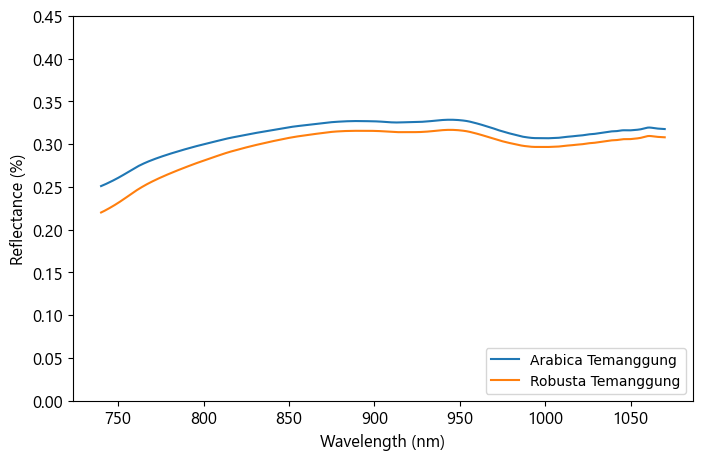

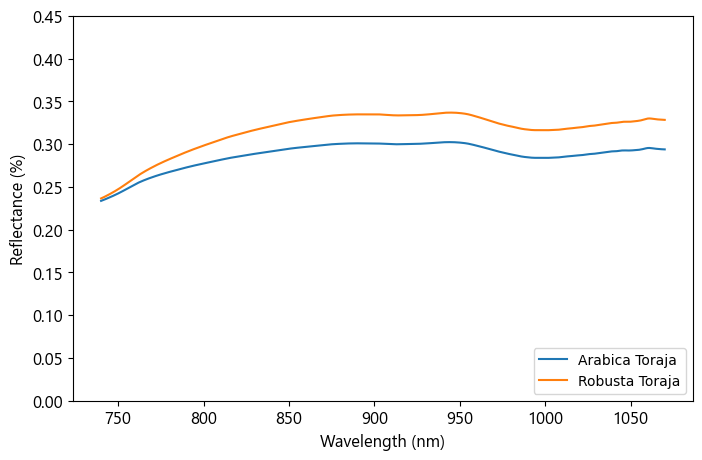

In [7]:
"""DETERMINE DATA VARIABLES"""

label_name_1 = ['Arabica Temanggung', 'Robusta Temanggung']
label_name_2 = ['Arabica Toraja', 'Robusta Toraja']

label_te, spectra_te, wls_te = variable_data(temanggung)
label_to, spectra_to, wls_to = variable_data(toraja)

_, spectra_rtenir, wls_te = variable_data(rtenir)
_, spectra_rtonir, wls_to = variable_data(rtonir)
_, spectra_atenir, wls_te = variable_data(atenir)
_, spectra_atonir, wls_to = variable_data(atonir)

"""OBTAIN AVERAGE SPECTRA"""
mean_rtenir = np.mean(spectra_rtenir, axis=0)
mean_rtonir = np.mean(spectra_rtonir, axis=0)
mean_atenir = np.mean(spectra_atenir, axis=0)
mean_atonir = np.mean(spectra_atonir, axis=0)


"""PLOT AVERAGE SPECTRA"""
plot_average_spectra(wls_te, mean_rtenir, mean_atenir, label_name_1)
plot_average_spectra(wls_to, mean_rtonir, mean_atonir, label_name_2)

In [13]:
"""RUN PLOT SPECTRA"""
#plot_spectra(wls_te, spectra_te)      # ------------------------------------ < CHANGE INPUT
#plot_spectra(wls_to, spectra_to)      # ------------------------------------ < CHANGE INPUT

"""PRE-PROCESSED SPECTRA"""
#vis_sma, vis_sgs, vis_msc, vis_snv, vis_sgd1, vis_sgd2 = preprocessing(spectra_te, wls_vis, 5, 1)
#nir_sma, nir_sgs, nir_msc, nir_snv, nir_sgd1, nir_sgd2 = preprocessing(spectra_to, wls_nir, 5, 1)

'PRE-PROCESSED SPECTRA'

In [14]:
"""LABEL ENCODING"""
encoder = LabelEncoder()
encoder.fit(label_te)
encoded_Y1 = encoder.transform(label_te)
encoded_Y2 = encoder.transform(label_to)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y1 = np_utils.to_categorical(encoded_Y1)
dummy_y2 = np_utils.to_categorical(encoded_Y2)

"""RUN PROGRAM"""
#PCA_score1 = pca1(spectra_te, wls_te, label_te, label_name_1, 3)
#PCA_score2 = pca1(spectra_to, wls_to, label_to, label_name_2, 3)
#PCA_LDA_score = lda2class(PCA_score1, label_te, label_name_1, 1)
#PLS_LDA_score = lda2class(PCA_score2, label_to, label_name_2, 1)
#ann(PCA_score1, dummy_y1, 3, 10, 10)
#ann(PCA_score2, dummy_y2, 3, 10, 10)

'RUN PROGRAM'

In [ ]:
#PCA2_score_nir_ori = pca2(spectra_nir, wls_nir, label_nir, label_name, 10)